# Impact of different systematic parameters on the diffuse fit
### Script to quantify systematic and statistical uncertainties of the fit using Asimov tests

In [1]:
import glob
import imp
import os

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook 
import matplotlib.colors as colors 
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.interpolate import griddata as scipygrid
from scipy.interpolate import UnivariateSpline

plt.style.use(r"~/.config/matplotlib/stylelib/latex.mplstyle")
myplt = imp.load_source('myplot', '/home/pfuerst/master_thesis/software/matplotlib_tools/myplot.py')
%matplotlib inline

EXAMPLE DAGMAN BUILD CALL FOR THIS ANALYSIS

python /home/pfuerst/master_thesis/software/NNMFit/resources/condor/submit_llhscan_precompile.py -o /data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE/delta_gamma --scan gamma_astro 1.5 2.7 50 --scan astro_norm 0.1 2.5 50 --each_scan_1d --log_dir /scratch/pfuerst/NNMlogs/delta_gamma --main_config /home/pfuerst/master_thesis/software/NNMFit/resources/configs/main_SPL.cfg --fix_default CR_grad barr_h barr_w barr_z barr_y --analysis_config /home/pfuerst/master_thesis/software/NNMFit/resources/configs/analysis_configs/asimov_SPL.yaml --override_configs /home/pfuerst/master_thesis/software/NNMFit/resources/configs/override_IC86_pass2_mapping_E_ACE.cfg

In [2]:
# global variables

# systematic fits
main_path = "/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE/"
systematics_paths = sorted(glob.glob(main_path+"*"))
for systematics_path in systematics_paths:
    fit_pickles = sorted(glob.glob(os.path.join(systematics_path, "*FitRes*")))
    fit_pickles = sorted(fit_pickles)
systematics = [os.path.split(path)[1] for path in systematics_paths]

#best fit 
best_fit_file = "/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE/no_systematics/Freefit.pickle"
best_fit = pd.read_pickle(best_fit_file)
best_gamma = best_fit['fit-result'][1]['gamma_astro']
best_phi = best_fit['fit-result'][1]['astro_norm']
min_llh = best_fit['fit-result'][0][1] #this is approx.=0 but it is correct to subtract it from all LLH values.

#truncated energy no systematics fit
path_trunc_nosyst = "/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/truncated/no_systematics"

#truncated energy best fit
path_trunc_nosyst_freefit = "/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/truncated/no_systematics/Freefit.pickle"

In [3]:
# processing class for a 2d-asimov scan of LLH space

class SingleSystematicScan(object):
    """class to load LLH values for a scan with just one free systematic parameter.
    """
    def __init__(self, parameter, path, best_fit_file):

        self.parameter = parameter
        self.path = os.path.join(path)
        self.scan_gamma_files = sorted(glob.glob(os.path.join(path, "*FitRes_gamma_astro*")))
        self.scan_phi_files = sorted(glob.glob(os.path.join(self.path, "*FitRes_astro_norm*")))
        self.status = False
        self.input_phi = 1.36 #problematic to hardcode. read config from systematics path?
        self.input_gamma = 2.37
        self.__best_fit = pd.read_pickle(best_fit_file)
        self.__best_llh = self.__best_fit['fit-result'][0][1]
        if len(self.scan_gamma_files)>0 and len(self.scan_phi_files)>0:
            self.status=True
        
    def fit_results(self):
        """loops over the fit files and loads the calculated llh values at the fixed phi(gamma) position.
        """
        gammas_scan_points = []
        phis_scan_points = []
        gamma_llhs = []
        phi_llhs = []
        if self.status==False:
            print("No Fit files detected. does this scan exist?")
            return None
        if self.status==True:
            for g in self.scan_gamma_files:
                current_fit = pd.read_pickle(g)
                current_gamma = current_fit["fixed-parameters"]["gamma_astro"]
                current_llh   = current_fit["fit-result"][0][1] 
                gammas_scan_points.append(current_gamma)
                gamma_llhs.append(current_llh)
            for p in self.scan_phi_files:
                current_fit = pd.read_pickle(p)
                current_phi = current_fit["fixed-parameters"]["astro_norm"]
                current_llh   = current_fit["fit-result"][0][1] 
                phis_scan_points.append(current_phi)
                phi_llhs.append(current_llh)  
        gamma_llhs = np.array(gamma_llhs)
        gamma_llhs = gamma_llhs[np.argsort(np.array(gammas_scan_points))]
        gammas_scan_points = np.sort(np.array(gammas_scan_points))
        
        phi_llhs = np.array(phi_llhs)
        phi_llhs = phi_llhs[np.argsort(np.array(phis_scan_points))]
        phis_scan_points = np.sort(np.array(phis_scan_points))

        gamma_dict = {"scan_points": np.array(gammas_scan_points),
                     "two_delta_llh": 2*(np.array(gamma_llhs)-self.__best_llh)}
        
        phi_dict = {"scan_points": np.array(phis_scan_points),
                   "two_delta_llh":2*(np.array(phi_llhs)-self.__best_llh)}
        return_dict = {"gamma" : gamma_dict,
                       "phi" : phi_dict}
        return return_dict

In [4]:
#truncated energy scan
scan_trunc_nosyst = SingleSystematicScan("no_systematics",path_trunc_nosyst, path_trunc_nosyst_freefit)
trunc_fit = scan_trunc_nosyst.fit_results()

In [5]:
# all systematic scans - takes a few seconds
all_params_results = {}
for systematic_parameter in systematics:
    print(systematic_parameter)
    scan= SingleSystematicScan(systematic_parameter, os.path.join(main_path, systematic_parameter), best_fit_file)
    fit_results = scan.fit_results()
    all_params_results[systematic_parameter] = fit_results

CR_grad
all_systematics
barr_h
barr_w
barr_y
barr_z
delta_gamma
no_systematics


In [6]:
# Wilk's theorem: -2DeltaLLH distribution is approx. Chi^2-distributed (here k=2). 
# use this to estimate 1,2,3 sigma confidence intervals in LLH landscape.
sigmas = [1,2,3]
levels = stats.chi2.ppf(1-2*stats.norm.sf(sigmas, 0, 1), 2) 
levelnames = []
for sigma in sigmas:
    levelnames.append(r"{} $\sigma$".format(sigma))
print(levels)

[ 2.29574893  6.18007431 11.82915808]


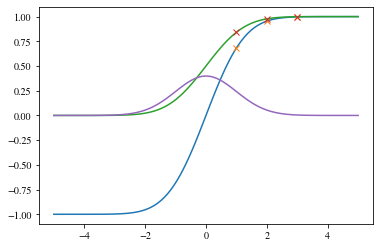

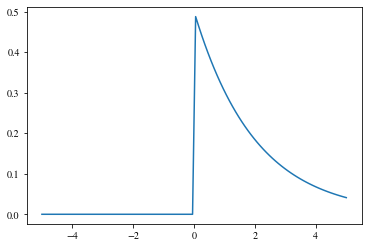

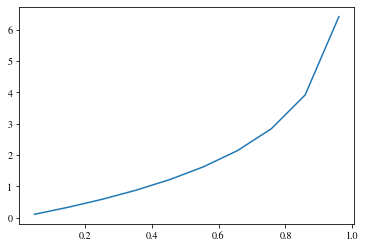

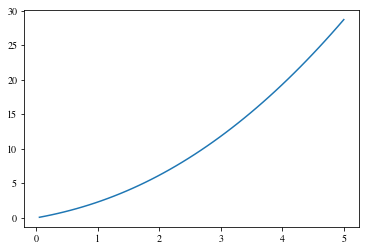

In [18]:
x = np.linspace(-5,5,100)
y  = stats.norm.sf(x, 0, 1)
sy = stats.norm.sf(sigmas, 0, 1)
gy = stats.norm.pdf(x,0,1)
plt.figure()
plt.plot(x, 1-2*y)
plt.plot(sigmas, 1-2*sy, linestyle="None", marker = "x") # this is just a fancy way of saying 68%, 95%, 99.7%
plt.plot(x, 1-y)
plt.plot(sigmas, 1-sy, linestyle="None", marker = "x")
plt.plot(x, gy)

plt.figure()
plt.plot(x, stats.chi2.pdf(x, 2) )

plt.figure()
plt.plot(x, stats.chi2.ppf(x, 2) )

plt.figure()
plt.plot(x, stats.chi2.ppf(1-2*stats.norm.sf(x, 0, 1), 2) )

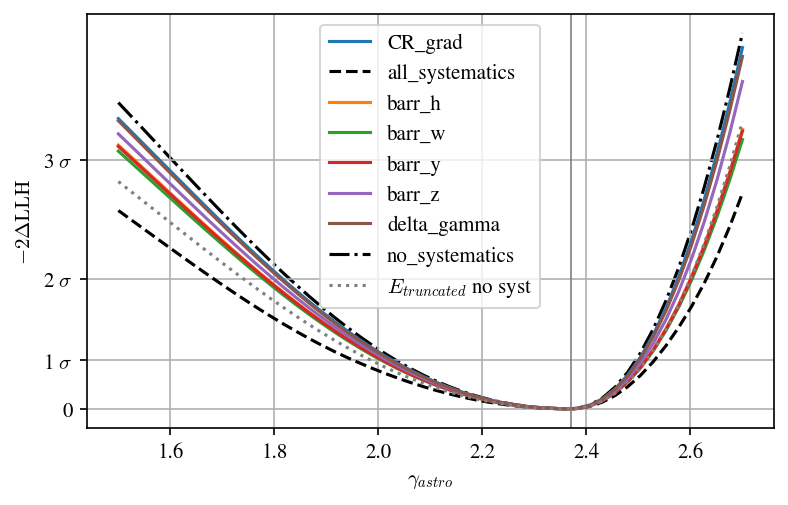

In [19]:
# plot: Asimov tests with gamma_astro: 2.37, astro_norm: 1.36
# no_systematics means all systematics parameters are fixed. 
# This does not purely reflect statistical uncertainty of the fit as the smearing of
# the energy reconstruction is also inherently contained.

plt.figure(figsize = myplt.set_size(ratio="golden"), dpi = 150)
for systematic_parameter in systematics:
    if systematic_parameter != "all_systematics" and systematic_parameter != "no_systematics":
        plt.plot(all_params_results[systematic_parameter]["gamma"]["scan_points"],
            all_params_results[systematic_parameter]["gamma"]["two_delta_llh"], label=systematic_parameter)
    elif systematic_parameter == "all_systematics":
        plt.plot(all_params_results[systematic_parameter]["gamma"]["scan_points"],
            all_params_results[systematic_parameter]["gamma"]["two_delta_llh"], label=systematic_parameter,
            color="black", linestyle = "--")
    elif systematic_parameter == "no_systematics":
        plt.plot(all_params_results[systematic_parameter]["gamma"]["scan_points"],
            all_params_results[systematic_parameter]["gamma"]["two_delta_llh"], label=systematic_parameter,
            color="black", linestyle = "-.", zorder = -1)
plt.axvline(best_gamma, color="grey", linewidth = 0.8)
    #plt.plot(full_results["gamma_scan_points"], full_results["gamma_llhs"], label="full_systematics")    
plt.plot(trunc_fit["gamma"]["scan_points"],
         trunc_fit["gamma"]["two_delta_llh"], label = "$E_{truncated}$ no syst", color="grey", linestyle = ":")
plt.legend()
plt.legend()
plt.xlabel("$\gamma_{astro}$")
plt.ylabel('$-2\Delta \mathrm{LLH}$',rotation=90)
plt.yticks([0,*levels], ["0", *levelnames])
plt.grid()

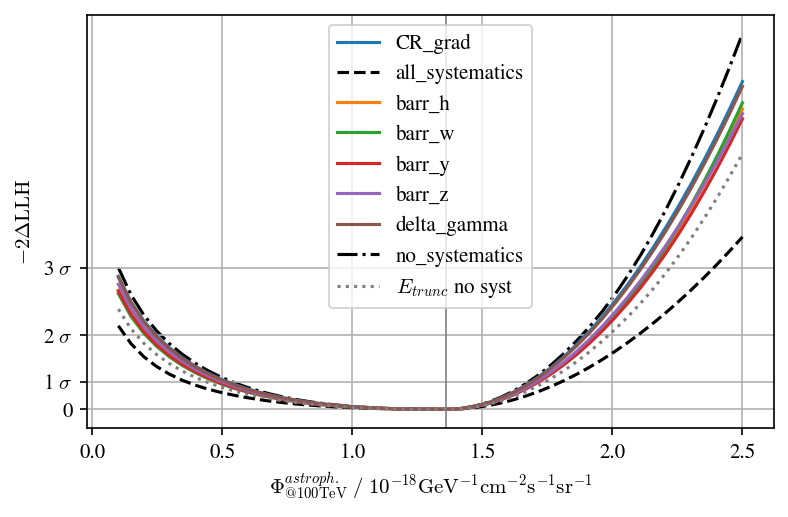

In [20]:
# same plot in Phi 
plt.figure(figsize = myplt.set_size(ratio="golden"), dpi = 150)
for systematic_parameter in systematics:
    if systematic_parameter != "all_systematics" and systematic_parameter != "no_systematics":
        plt.plot(all_params_results[systematic_parameter]["phi"]["scan_points"],
            all_params_results[systematic_parameter]["phi"]["two_delta_llh"], label=systematic_parameter)
    #elif systematic_parameter == any(["all_systematics","no_systematics"]):
    elif systematic_parameter == "all_systematics":
        plt.plot(all_params_results[systematic_parameter]["phi"]["scan_points"],
            all_params_results[systematic_parameter]["phi"]["two_delta_llh"], label=systematic_parameter,
            color="black", linestyle = "--")
    elif systematic_parameter == "no_systematics":
        plt.plot(all_params_results[systematic_parameter]["phi"]["scan_points"],
            all_params_results[systematic_parameter]["phi"]["two_delta_llh"], label=systematic_parameter,
            color="black", linestyle = "-.", zorder = -1)
#plt.plot(full_results["gamma_scan_points"], full_results["gamma_llhs"], label="full_systematics") 
plt.plot(trunc_fit["phi"]["scan_points"], trunc_fit["phi"]["two_delta_llh"], label = "$E_{trunc}$ no syst", linestyle = ":",color="grey")
plt.axvline(best_phi, color="grey", linewidth = 0.8)
plt.legend()
plt.xlabel("$\Phi^{astroph.}_{@100 \mathrm{TeV}} $ $/$ $ 10^{-18} \mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1} \mathrm{sr}^{-1}$") # phi-->0 is excluded
plt.ylabel('$-2\Delta \mathrm{LLH}$',rotation=90)
plt.yticks([0,*levels], ["0", *levelnames])
plt.grid()

In [24]:
def delta_ratio(x_initial, y_numerator, y_denominator, y_position):
    """Function to calculate the widths of two distributions around a minimum.
    x_initial : array of x values
    y_numerator : array of y values of numerator distribution corresponding to x_initial
    y_denominator : array of y values of denominator distribution
    y_position : position on y-axis where the distribution widths are calculated
    
    returns:
    delta_num : width of numerator distr. at y_position
    delta_denom : width of denominator distr. at y_position.
    """
    yreduced_num = np.array(y_numerator) - y_position
    freduced_num = UnivariateSpline(x_initial, yreduced_num, s=0)
    delta_num = freduced_num.roots()[1]- freduced_num.roots()[0]
    
    yreduced_denom = np.array(y_denominator) - y_position
    freduced_denom = UnivariateSpline(x_initial, yreduced_denom, s=0)
    delta_denom = freduced_denom.roots()[1]- freduced_denom.roots()[0]
    return delta_num, delta_denom

def get_x_from_y(y_position, x_values, y_values, x_center = 0):
    """estimates x values for certain y value in 1-D distribution.
    returns: all x values where this distribution reaches the value y_position.
    """
    y_reduced = np.array(y_values) - y_position
    f_reduced = UnivariateSpline(x_values, y_reduced, s=0)
    deltas = []
    for root in f_reduced.roots():
        deltas.append(root-x_center)
    return deltas

def sigma_syst_stat_ratio(sigma_tot, sigma_stat):
    return np.sqrt((sigma_tot/sigma_stat)**2 -1)

In [26]:
# gamma direction.
gamma_asimov = 2.37
widths_all_syst_neg, widths_all_syst_pos = get_x_from_y(levels[0], all_params_results["all_systematics"]["gamma"]["scan_points"],all_params_results["all_systematics"]["gamma"]["two_delta_llh"], x_center = gamma_asimov)
widths_no_syst_neg,  widths_no_syst_pos  = get_x_from_y(levels[0], all_params_results["no_systematics"]["gamma"]["scan_points"], all_params_results["no_systematics"]["gamma"]["two_delta_llh"], x_center = gamma_asimov)

sigma_ratio_pos = sigma_syst_stat_ratio(widths_all_syst_pos, widths_no_syst_pos)
sigma_ratio_neg = sigma_syst_stat_ratio(widths_all_syst_neg, widths_no_syst_neg)
print("one-sided ratios at 1 sigma (gamma) (=factor between systematic and non-systematic error)")
print(sigma_ratio_neg, sigma_ratio_pos)


num_g, denom_g = delta_ratio(all_params_results["all_systematics"]["gamma"]["scan_points"], 
                         all_params_results["all_systematics"]["gamma"]["two_delta_llh"],
                         all_params_results["no_systematics"]["gamma"]["two_delta_llh"],
                         y_position = levels[0])
ratio_g = sigma_syst_stat_ratio(num_g, denom_g)
print("two-sided ratios at 1 sigma (gamma)")
print(ratio_g)

one-sided ratios at 1 sigma (gamma) (=factor between systematic and non-systematic error)
0.7404328978868586 0.8062243225388249
two-sided ratios at 1 sigma (gamma)
0.758636316656161


In [28]:
# phi direction.
phi_asimov = 1.36
widths_all_syst_neg, widths_all_syst_pos = get_x_from_y(levels[0], all_params_results["all_systematics"]["phi"]["scan_points"],all_params_results["all_systematics"]["phi"]["two_delta_llh"], x_center = phi_asimov)
widths_no_syst_neg,  widths_no_syst_pos  = get_x_from_y(levels[0], all_params_results["no_systematics"]["phi"]["scan_points"], all_params_results["no_systematics"]["phi"]["two_delta_llh"], x_center = phi_asimov)

sigma_ratio_pos = sigma_syst_stat_ratio(widths_all_syst_pos, widths_no_syst_pos)
sigma_ratio_neg = sigma_syst_stat_ratio(widths_all_syst_neg, widths_no_syst_neg)
print("one-sided ratios at 1 sigma (Phi) (=factor between systematic and non-systematic error)")
print(sigma_ratio_neg, sigma_ratio_pos)


num_p, denom_p = delta_ratio(all_params_results["all_systematics"]["phi"]["scan_points"], 
                         all_params_results["all_systematics"]["phi"]["two_delta_llh"],
                         all_params_results["no_systematics"]["phi"]["two_delta_llh"],
                         y_position = levels[0])
ratio_p = sigma_syst_stat_ratio(num_p, denom_p)
print("two-sided ratios at 1 sigma (Phi)")
print(ratio_p)

one-sided ratios at 1 sigma (Phi) (=factor between systematic and non-systematic error)
0.6895461099944435 0.9734247233034805
two-sided ratios at 1 sigma (Phi)
0.7749014734586605


In [29]:
# plot left/right hand side sigmas for gamma and for phi = 4 plots

# 1,1 gamma left       1,2 gamma right

# 2,1 phi left         2,2 phi right

In [30]:
many_levels = np.linspace(1,6,100)

In [31]:
print(levels)

[ 2.29574893  6.18007431 11.82915808]


In [51]:
gamma_left  = []
gamma_right = []
gamma_tot = []
for level in many_levels:
    widths_all_syst_neg, widths_all_syst_pos = get_x_from_y(level, all_params_results["all_systematics"]["phi"]["scan_points"],all_params_results["all_systematics"]["phi"]["two_delta_llh"], x_center = phi_asimov)
    widths_no_syst_neg,  widths_no_syst_pos  = get_x_from_y(level, all_params_results["no_systematics"]["phi"]["scan_points"], all_params_results["no_systematics"]["phi"]["two_delta_llh"],  x_center = phi_asimov)
    sigma_ratio_pos = sigma_syst_stat_ratio(widths_all_syst_pos, widths_no_syst_pos)
    sigma_ratio_neg = sigma_syst_stat_ratio(widths_all_syst_neg, widths_no_syst_neg)
    gamma_left.append(sigma_ratio_neg)
    gamma_right.append(sigma_ratio_pos)
    
    
    num_g, denom_g = delta_ratio(all_params_results["all_systematics"]["gamma"]["scan_points"], 
                             all_params_results["all_systematics"]["gamma"]["two_delta_llh"],
                             all_params_results["no_systematics"]["gamma"]["two_delta_llh"],
                             y_position = level)
    ratio_gamma = sigma_syst_stat_ratio(num_g, denom_g)
    gamma_tot.append(ratio_gamma)

In [63]:
phi_left  = []
phi_right = []
phi_tot = []
for level in many_levels:
    widths_all_syst_neg, widths_all_syst_pos = get_x_from_y(level, all_params_results["all_systematics"]["phi"]["scan_points"],all_params_results["all_systematics"]["phi"]["two_delta_llh"], x_center = phi_asimov)
    widths_no_syst_neg,  widths_no_syst_pos  = get_x_from_y(level, all_params_results["no_systematics"]["phi"]["scan_points"], all_params_results["no_systematics"]["phi"]["two_delta_llh"],  x_center = phi_asimov)
    sigma_ratio_pos = sigma_syst_stat_ratio(widths_all_syst_pos, widths_no_syst_pos)
    sigma_ratio_neg = sigma_syst_stat_ratio(widths_all_syst_neg, widths_no_syst_neg)
    phi_left.append(sigma_ratio_neg)
    phi_right.append(sigma_ratio_pos)
    
    
    num_g, denom_g = delta_ratio(all_params_results["all_systematics"]["phi"]["scan_points"], 
                             all_params_results["all_systematics"]["phi"]["two_delta_llh"],
                             all_params_results["no_systematics"]["phi"]["two_delta_llh"],
                             y_position = level)
    ratio_phi = sigma_syst_stat_ratio(num_g, denom_g)
    phi_tot.append(ratio_phi)

In [72]:
frame = 0

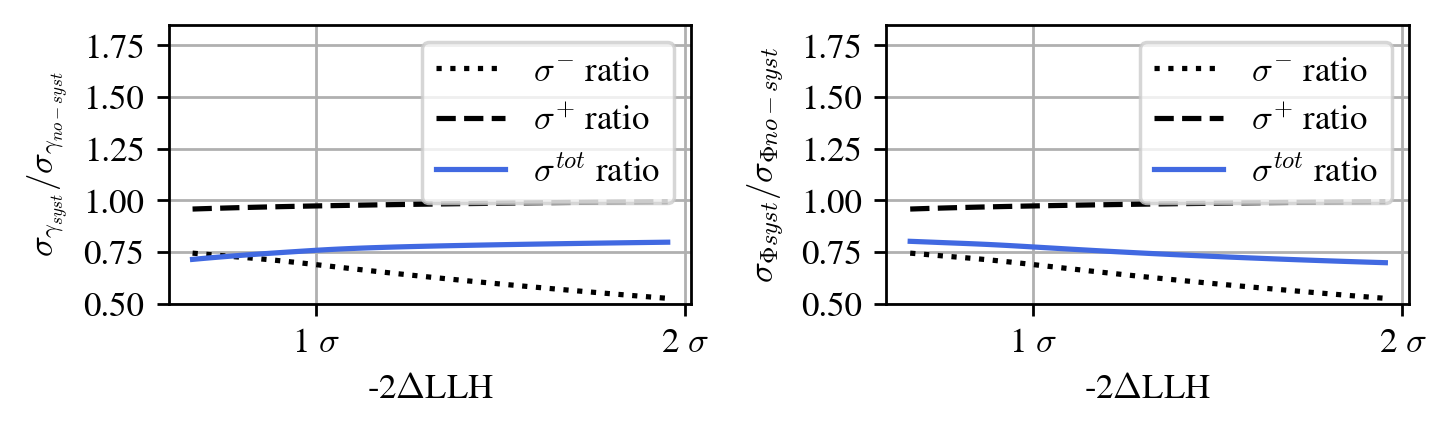

In [106]:
mysize = myplt.set_size(subplots = (1,2), ratio = "golden", squeeze_height = 1)

fig, (ax1,ax2) = plt.subplots(1,2,figsize = mysize, dpi = 250)

tot_col = "royalblue"
plus_col = "black"
minus_col = "black"
# ax1
ax1.plot(many_levels, gamma_left,  label = "$\sigma^{-}$ ratio",  color = minus_col, linestyle = ":")
ax1.plot(many_levels, gamma_right, label = "$\sigma^{+}$ ratio",  color = plus_col, linestyle = "--")
ax1.plot(many_levels, gamma_tot,   label = "$\sigma^{tot}$ ratio",color = tot_col)

legend = ax1.legend(loc="upper right")#framealpha = 1
frame = legend.get_frame()
#frame.set_facecolor('white')
ax1.grid(True)
ax1.set_xticks(levels[:-1])
ax1.set_xticklabels(levelnames[:-1])
ax1.set_xlabel("-2$\Delta$LLH")
ax1.set_yticks([0.5,0.75,1.0,1.25,1.5, 1.75])
#ax1.yaxis.set_tick_params(which='both')
ax1.set_ylim(0.5,1.85)
ax1.set_ylabel("$\sigma_{\gamma_{syst}} / \sigma_{\gamma_{no-syst}}$")
# ax2
ax2.plot(many_levels, phi_left,  label = "$\sigma^{-}$ ratio",   color = minus_col, linestyle = ":")
ax2.plot(many_levels, phi_right, label = "$\sigma^{+}$ ratio",   color = plus_col, linestyle = "--")
ax2.plot(many_levels, phi_tot,   label = "$\sigma^{tot}$ ratio", color = tot_col)

legend = ax2.legend(loc="upper right")
frame = legend.get_frame()
#frame.set_facecolor('white')
ax2.grid(True)
ax2.set_ylabel("$\sigma_{\Phi{syst}} / \sigma_{\Phi{no-syst}}$")
ax2.set_xlabel("-2$\Delta$LLH")
ax2.set_yticks([0.5,0.75,1.0,1.25,1.5, 1.75])
ax2.set_ylim(0.5,1.85)
ax2.set_xticks(levels[:-1])
ax2.set_xticklabels(levelnames[:-1])
plt.tight_layout()
plt.savefig("/home/pfuerst/master_thesis/plots/NNMFit/analysis/stat_plus1_syst_stat_ratios.png")


In [86]:
print(np.mean(np.hstack((gamma_left, gamma_right, gamma_tot))))
print(np.mean(np.hstack((phi_left, phi_right, phi_tot))))

print(np.std(np.hstack((gamma_left, gamma_right, gamma_tot))))
print(np.std(np.hstack((phi_left, phi_right, phi_tot))))

0.7948628158856027
0.7868289141319518
0.1486723752030955
0.1509140123525501


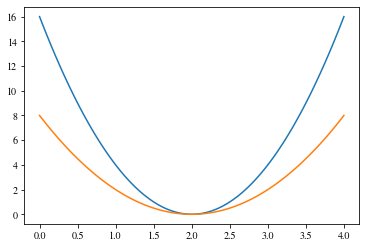

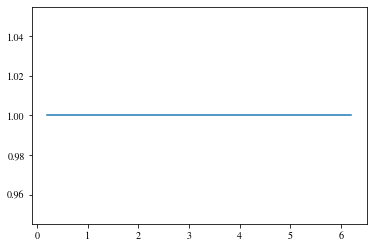

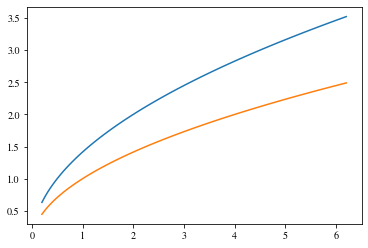

In [106]:
#test: 2 parabolas and one is half as wide as the other:
#results: squared ratio is =1 and constant.
x_test = np.linspace(0,4,100)
y_test = (x_test-2)**2*4
y_test_wide = (x_test-2)**2*2

plt.figure()
plt.plot(x_test,y_test)
plt.plot(x_test,y_test_wide)

nums = []
denoms = []
ratios = []
for delta_llh in delta_llhs:
    num, denom = delta_ratio(x_test, y_test_wide, y_test,
                         y_position = delta_llh)
    nums.append(num)
    denoms.append(denom)
    ratios.append(sigma_syst_stat_ratio(num, denom))
    
plt.figure()
plt.plot(delta_llhs, ratios)

plt.figure()
plt.plot(delta_llhs, nums)
plt.plot(delta_llhs, denoms)

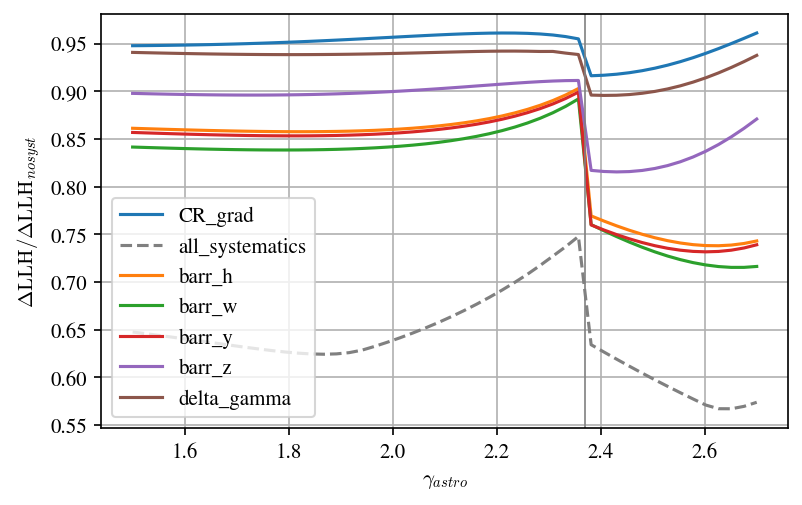

In [123]:
plt.figure(figsize = myplt.set_size(ratio="golden"), dpi = 150)
no_syst_gamma_vals = all_params_results["no_systematics"]["gamma"]["two_delta_llh"]
for systematic_parameter in systematics:
    if systematic_parameter != "all_systematics" and systematic_parameter != "no_systematics":
        plt.plot(all_params_results[systematic_parameter]["gamma"]["scan_points"],
            all_params_results[systematic_parameter]["gamma"]["two_delta_llh"]/no_syst_gamma_vals, label=systematic_parameter)
    elif systematic_parameter == "all_systematics":
        plt.plot(all_params_results[systematic_parameter]["gamma"]["scan_points"],
            all_params_results[systematic_parameter]["gamma"]["two_delta_llh"]/no_syst_gamma_vals, label=systematic_parameter,
            color="grey", linestyle = "--")
    
    #plt.plot(full_results["gamma_scan_points"], full_results["gamma_llhs"], label="full_systematics")    
plt.axvline(best_gamma, color="grey", linewidth = 0.8)
plt.legend()
plt.legend()
plt.xlabel("$\gamma_{astro}$")
plt.ylabel('$\Delta \mathrm{LLH} / \Delta \mathrm{LLH}_{no syst}$',rotation=90)
#plt.yticks([0,*levels], ["0", *levelnames])
plt.grid()

In [203]:
np.sqrt(0.65**(-2) -1)

1.1691295502746664

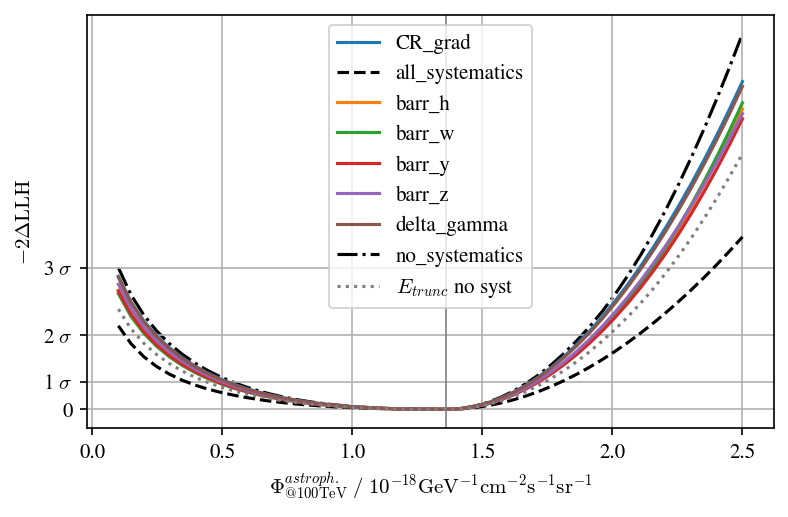

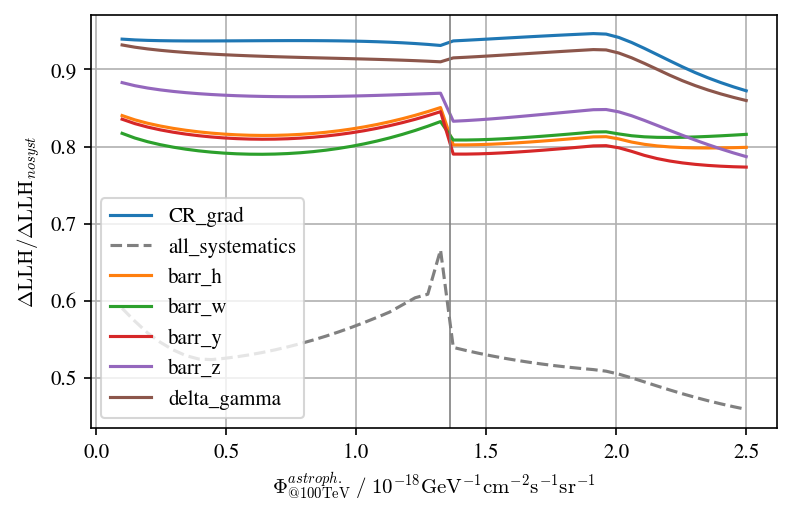

In [125]:
plt.figure(figsize = myplt.set_size(ratio="golden"), dpi = 150)
no_syst_gamma_vals = all_params_results["no_systematics"]["phi"]["two_delta_llh"]
for systematic_parameter in systematics:
    if systematic_parameter != "all_systematics" and systematic_parameter != "no_systematics":
        plt.plot(all_params_results[systematic_parameter]["phi"]["scan_points"],
            all_params_results[systematic_parameter]["phi"]["two_delta_llh"]/no_syst_gamma_vals, label=systematic_parameter)
    elif systematic_parameter == "all_systematics":
        plt.plot(all_params_results[systematic_parameter]["phi"]["scan_points"],
            all_params_results[systematic_parameter]["phi"]["two_delta_llh"]/no_syst_gamma_vals, label=systematic_parameter,
            color="grey", linestyle = "--")
    
    #plt.plot(full_results["gamma_scan_points"], full_results["gamma_llhs"], label="full_systematics")    
plt.axvline(best_phi, color="grey", linewidth = 0.8)
plt.legend()
plt.legend()
plt.xlabel("$\Phi^{astroph.}_{@100 \mathrm{TeV}} $ $/$ $ 10^{-18} \mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1} \mathrm{sr}^{-1}$") # phi-->0 is excluded
plt.ylabel('$\Delta \mathrm{LLH} / \Delta \mathrm{LLH}_{no syst}$',rotation=90)
#plt.yticks([0,*levels], ["0", *levelnames])
plt.grid()

In [174]:
#To Do : find a good measure for 1d percent improvement 
#(average of 10? LLH levels in both axis, maybe average this as well)
#if you add all % improvements you should end up roughly at the % improvement of "no_systematics"

In [26]:
def interp(axis, x,y, c):
    interpolated = scipy.interpolate.interp1d(x,y,bounds_error = True)
    xfine = np.linspace(min(x), max(x), 1000)
    yfine = interpolated(xfine)
    axis.plot(xfine, yfine, color = c, linewidth = 0.5)
    return xfine, yfine

In [27]:
import scipy
def get_delta_x_from_y(x_fine, y_fine, y_to_find):
    deltas = []
    for y in y_to_find:
        yreduced = np.array(y_fine) - y
        freduced = scipy.interpolate.UnivariateSpline(x_fine, yreduced, s=0)
        delta = freduced.roots()[1]- freduced.roots()[0]
        deltas.append(delta)
    return deltas

In [28]:
def get_max_deltallh(results, var = "phi"):
    """get maximum possible value where all methods still have results.
    results: dictionary with all stat+1 fit results.
    returns: minimum value which all methods reach at the edge."""
    values = []
    for result in results:
        print(result)
        value = result[var]["two_delta_llh"][0]
        if args[var]["two_delta_llh"][0] > result[var]["two_delta_llh"][-1]:
            value = result[var]["two_delta_llh"][-1]
        values.append(value)
    return min(values)

In [169]:
max_delta_llh = stats.chi2.ppf(1-2*stats.norm.sf(2, 0, 1), 2)

In [197]:
from scipy.interpolate import interp1d

In [191]:
def percent_increase(y_numerator, y_denominator, x_initial, n_steps = 100, y_max = max_delta_llh):
    y_min = min(min(y_numerator), min(y_denominator))
    y_steps = np.linspace(y_min, y_max, n_steps)
    #at y_steps get x roots for both num and denom.
    delta_num = []
    delta_denom = []
    for y_step in y_steps[1:]: #lowest step can be problematic
        yreduced_num = np.array(y_numerator) - y_step
        freduced_num = scipy.interpolate.UnivariateSpline(x_initial, yreduced_num, s=0)
        delta_num.append(freduced_num.roots()[1]- freduced_num.roots()[0])
        
        yreduced_denom = np.array(y_denominator) - y_step
        freduced_denom = scipy.interpolate.UnivariateSpline(x_initial, yreduced_denom, s=0)
        delta_denom.append(freduced_denom.roots()[1]- freduced_denom.roots()[0])
    ratios = np.array(delta_num)/np.array(delta_denom)
    return np.mean(ratios), np.std(ratios)

In [192]:
y_num1 = all_params_results["all_systematics"]["phi"]["two_delta_llh"]
y_denom1 = all_params_results["no_systematics"]["phi"]["two_delta_llh"]
x_init1 = all_params_results["all_systematics"]["phi"]["scan_points"]

In [193]:
test_m, test_std = percent_increase(y_num1, y_denom1,x_init1)

In [195]:
test_m

1.253543344657431

In [196]:
test_std

0.022882047311884007

In [202]:
means = []
for syst in all_params_results.del("no_systematics").keys():
    print(syst)

SyntaxError: invalid syntax (<ipython-input-202-c76e5cbc6637>, line 2)

In [ ]:
#plot percent increase vs. method.


plt.figure()





In [174]:
test, test2 = percent_increase(all_params_results["all_systematics"]["phi"]["two_delta_llh"], all_params_results["no_systematics"]["phi"]["two_delta_llh"], x_vals = all_params_results["all_systematics"]["phi"]["scan_points"])

IndexError: index 1 is out of bounds for axis 0 with size 0

In [156]:
test

0.001063646748661995

In [152]:
max_delta_llh

6.180074306244173

In [137]:
all_params_results["no_systematics"]["phi"]["two_delta_llh"]

array([1.18348533e+01, 9.55757234e+00, 7.87802335e+00, 6.56333183e+00,
       5.49886611e+00, 4.61859330e+00, 3.88048947e+00, 3.25587965e+00,
       2.72415518e+00, 2.26989391e+00, 1.88117408e+00, 1.54852980e+00,
       1.26427486e+00, 1.02204820e+00, 8.16498802e-01, 6.43061967e-01,
       4.97796766e-01, 3.77265548e-01, 2.78443652e-01, 1.98650632e-01,
       1.35497207e-01, 8.68443511e-02, 5.07711172e-02, 2.55494453e-02,
       9.62425862e-03, 1.59757677e-03, 4.09199018e-03, 8.81973738e-02,
       2.81398348e-01, 5.84085640e-01, 9.96342261e-01, 1.51798301e+00,
       2.14859456e+00, 2.88757388e+00, 3.73416263e+00, 4.68747823e+00,
       5.74653997e+00, 6.91029172e+00, 8.18956306e+00, 9.61251111e+00,
       1.11785418e+01, 1.28856643e+01, 1.47319133e+01, 1.67153536e+01,
       1.88340835e+01, 2.10862373e+01, 2.34699869e+01, 2.59835425e+01,
       2.86251534e+01, 3.13931084e+01])

In [141]:
levels = stats.chi2.ppf(1-2*stats.norm.sf([1,2,3], 0, 1), 2)   #the list is the sigma levels you want to plot
#find the max of the lowest curve. raise warning if it is, say, below 1 sigma area, otherwise take 10 points between 0-2sigma area.
#and evaluate the ratio to "no_syst" there. 

#this is then the % increase (with errorbar maybe?)

In [ ]:
#plot x: systematic, y: percent uncertainty from this particular one.

## Interesting Questions:
### Which is the dominant systematic? dominant detector systematic? dominant atmospheric systematic?
### How do systematic uncertainties compare with the gain in accuracy from using a new reco E?
i.e do scans with 0 syst and with full syst for truncated and for BDT
## Followup-Questions:
### Systematics-1 sets: how much can we gain by reducing which systematic? by which can we gain the most?
atmospheric/CR? or detector?
how do systematic improvements compare to reco E upgrade?
do scan with all syst for all energy recos and do scan-worst systematic for all energy recos. This will show if the energy reco upgrade is negligible next to systematics or if it is vastly more important than upgrading systematics treatment (or if its on the same level, meaning both are very useful right now. Study this for more livetime as well)
### How many years do we need to be systematics-dominated? Are we already? 

In [131]:
systematics_paths[0]

'/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/CR_grad'

In [134]:
cr_grad_scan = SingleSystematicScan("CR_grad")

In [135]:
results = cr_grad_scan.fit_results()

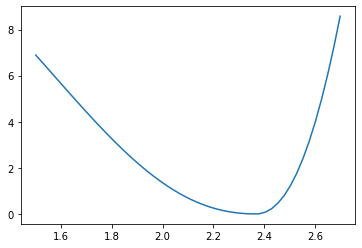

In [136]:
%matplotlib inline
plt.figure()
plt.plot(results["gamma_scan_points"], results["gamma_llhs"])

In [85]:
gammas = []
phis   = []
llhs   = []
points = []
for f in fit_files:
    current_fit = pd.read_pickle(f)
    current_gamma = current_fit["fixed-parameters"]["gamma_astro"]
    current_phi   = current_fit["fixed-parameters"]["astro_norm"]
    current_llh   = current_fit["fit-result"][0][1]
    
    gammas.append(current_gamma)
    phis.append(current_phi)
    llhs.append(current_llh)
    points.append([current_gamma, current_phi])
gammas = np.array(gammas)
phis   = np.array(phis)
llhs   = np.array(llhs)
#llhs = -2*llhs

NameError: name 'fit_files' is not defined

In [ ]:
class LLHScan(object):
    def __init__(self, path):
        self.path = path
        self.files = []
        
        self.n_grid = 50
        self.gammas = []
        self.phis = []
        self.llhs = []
        self.points = []
        #self.levels = stats.chi2.ppf(1-2*stats.norm.sf([1,2,3], 0, 1), 2)
        for file in os.listdir(self.path):
            if file.endswith(".pickle") and file.startswith("FitRes"):
                self.files.append(os.path.join(self.path, file))
        for f in self.files:
            current_fit = pd.read_pickle(f)
            
            current_gamma = current_fit["fixed-parameters"]["gamma_astro"]
            current_phi   = current_fit["fixed-parameters"]["astro_norm"]
            current_llh   = current_fit["fit-result"][0][1]
            
            self.gammas.append(current_gamma)
            self.phis.append(current_phi)
            self.llhs.append(current_llh)
            self.points.append([current_gamma, current_phi])  